# Kaggle Workflow Project (Titanic Dataset)

Kaggle is a web site that offers dataset prediction competitions for aspiring data scientists all over the globe.  Submitting to Kaggle offers good practice in all aspects of data science, from:

- Data Cleaning

- Feature Engineering

- Feature Selection

- Algorithm choice and customization

- Overfitting feedback.

When you submit a set of predictions to Kaggle, you will receive immediate feedback on how accurate you are compared to others in your field, although cheating is rampant in the top ranks on the leaderboard.  Having a designed work-flow to help speed up and control quality on your Kaggle submissions can save us time and energy down the road on our data science careers. 

## Importing Dataset into Pandas

First, we need to download the dataset from Kaggle (already done), and then import it into Pandas so we can easily manipulate it using out Python knowledge.

Kaggle will always have two different data files.

Train: The train file will contain all columns of the dataset, and a majority of the rows.  It also contains whatever column you are predicting for these rows.  This way, you'll have a large subset of data to train you Machine Learning algorithm on, so it can 'learn' by predicting the true answer.

Holdout: The holdout file contains all columns from the dataset, but without the column you would be predicting.  This dataset is a smaller proportion of the total amount of data.  This is the file we will be using our trained models to predict, and submitting the answers to Kaggle for scoring.

In [709]:
# importing necessary modules
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline


# reading dataset into pandas
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

In [710]:
print(train.shape)

train.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [711]:
print(holdout.shape)

holdout.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Helper Functions

Before proceeding, we have a file containing helper functions in a .py file that we will load into our Jupyter notebook, to help us down the line in this project.

In [712]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

## Creating a New Function Combining All of Our Functions

We will now create a single function called "clean_process" which will, in the correct order, combine all the functions from the previous cell.

In [713]:
# clean_process function

def clean_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    
    #list of columns to turn into dummy columns
    dummy_cols = ["Age_categories", "Fare_categories","Title", "Cabin_type"]

    for col in dummy_cols:
        df = create_dummies(df,col)
        
    return df


# running our new function to clean and process the train and holdout datasets
train = clean_process(train)
holdout = clean_process(holdout)

In [714]:
# checking to make no more null values exist
train.isnull().sum()

PassengerId                   0
Survived                      0
Pclass                        0
Name                          0
Sex                           0
Age                           0
SibSp                         0
Parch                         0
Ticket                        0
Fare                          0
Embarked                      0
Age_categories                0
Fare_categories               0
Title                         0
Cabin_type                    0
Age_categories_Missing        0
Age_categories_Infant         0
Age_categories_Child          0
Age_categories_Teenager       0
Age_categories_Young Adult    0
Age_categories_Adult          0
Age_categories_Senior         0
Fare_categories_0-12          0
Fare_categories_12-50         0
Fare_categories_50-100        0
Fare_categories_100+          0
Title_Master                  0
Title_Miss                    0
Title_Mr                      0
Title_Mrs                     0
Title_Officer                 0
Title_Ro

In [715]:
# checking to make no more null values exist
holdout.isnull().sum()

PassengerId                   0
Pclass                        0
Name                          0
Sex                           0
Age                           0
SibSp                         0
Parch                         0
Ticket                        0
Fare                          0
Embarked                      0
Age_categories                0
Fare_categories               0
Title                         0
Cabin_type                    0
Age_categories_Missing        0
Age_categories_Infant         0
Age_categories_Child          0
Age_categories_Teenager       0
Age_categories_Young Adult    0
Age_categories_Adult          0
Age_categories_Senior         0
Fare_categories_0-12          0
Fare_categories_12-50         0
Fare_categories_50-100        0
Fare_categories_100+          0
Title_Master                  0
Title_Miss                    0
Title_Mr                      0
Title_Mrs                     0
Title_Officer                 0
Title_Royalty                 0
Cabin_ty

## The General Workflow.

1) Data Exploration
    - In this stage, we will look at the data, getting a feel for which information might be useful.  This can involve everything from measuring correlations, using domain knowledge, to watching out for collinearity between columns.
    

2) Feature Engineering
    - Feature engineering involves the creation of new columns by manipulating or combining any combination of already existing columns within the dataset.  This can involve the 'binning' of numerical columns, extracting information from string-type columns, etc.
    
   
3) Feature Selection
    - Feature Selection is where we actually pick all the columns that we will be training our ML algorithm on, in order to make accurate predictions.  In this case, any column that would help us to predict whether a passenger on the Titanic survived or not, based on whichever columns we think will aid us in that goal.  Fortunately for us, the sklearn of Python has a few tools that can help us with feature selection. 
    
    
4) Model Selection/Tuning
    - This is the step where we train a Machine Learning model on our selected columns, and then optimize its hyperparameters to achieve better results on our predictions.  We might train and optimize multiple types of machine learning algorithms, but in this case, we are working to predict a yes/no binary answer.  We will be using logistic regression, random forests, and K nearest neighbors.  If we were predicting a linear answer, we might try linear regression or random forest regression.  In either case, we would want to optimize each algorithm.  
    
   
5) Submit to Kaggle
    - After performing all four earlier steps, we now need to format the data properly to submit to kaggle.  Once submitted, we can see how well our predictions scored compared to our peers.  At this point, it's likely time to start back at step one, dial things in a little better at all four stages, and resubmit to Kaggle until we are pleased with our scores.

## Data Exploration

Let's dive into the data set and see if we can pick up any patterns that may help us to predict survival rates

In [716]:
# viewing data types for columns
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 41 columns):
PassengerId                   891 non-null int64
Survived                      891 non-null int64
Pclass                        891 non-null int64
Name                          891 non-null object
Sex                           891 non-null object
Age                           891 non-null float64
SibSp                         891 non-null int64
Parch                         891 non-null int64
Ticket                        891 non-null object
Fare                          891 non-null float64
Embarked                      891 non-null object
Age_categories                891 non-null category
Fare_categories               891 non-null category
Title                         891 non-null object
Cabin_type                    891 non-null object
Age_categories_Missing        891 non-null uint8
Age_categories_Infant         891 non-null uint8
Age_categories_Child          891 non-null uin

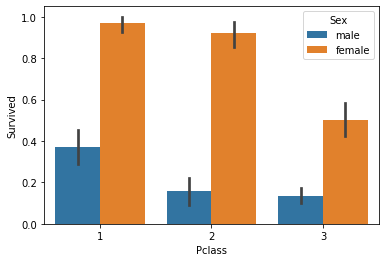

In [717]:
# looking at gender, Pclass and survival rates

sns.barplot(data=train, x='Pclass', y='Survived', hue='Sex')
plt.show()

We can see that gender has a huge amount of impact on survival across different Pclass values.  PClass is the class of tickets sold, with Pclass=1 being a first class ticket, Pclass=3 being a third class ticket, etc.  Pclass also looks like a good predictor of survival, with the likelier more wealthy passengers more likely to survive.

However, even the poorest women were more likely to survive than the wealthiest of men.

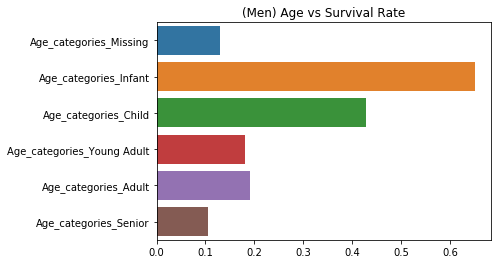

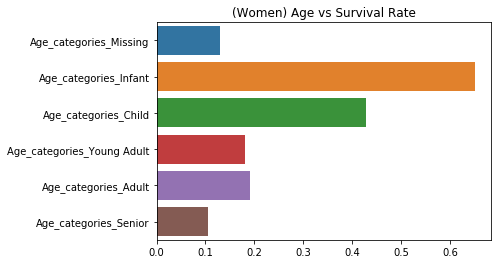

In [718]:
# looking at age groups, gender and survival
age_cats = ['Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Child', 'Age_categories_Young Adult',
                 'Age_categories_Adult', 'Age_categories_Senior']

# dictionary to hold age group and survival rate for men
age_male_survival = {}

# subset of training data of only men
train_male = train[train.Sex == 'male']

# looping through each age group, calculating survival rate and 
# importing that info to our dictionary
for age in age_cats:
    total_in_cat = train_male[train_male[age] == 1].shape[0]
    total_survived = train_male[train_male[age] == 1].Survived.sum()
    age_male_survival[age] = total_survived / total_in_cat
    
#creating new Series to graph
male_surv = pd.Series(age_male_survival)

# plotting male survival rates by age

sns.barplot(x=male_surv, y=male_surv.index)
plt.title('(Men) Age vs Survival Rate')
plt.show()




# dictionary to hold age group and survival rate for women
age_w_survival = {}

# subset of training data of only women
train_w = train[train.Sex == 'female']

# looping through each age group, calculating survival rate and 
# importing that info to our dictionary
for age in age_cats:
    total_in_cat = train_w[train_w[age] == 1].shape[0]
    total_survived = train_w[train_w[age] == 1].Survived.sum()
    age_w_survival[age] = total_survived / total_in_cat
    
#creating new Series to graph
w_surv = pd.Series(age_w_survival)

# plotting female survival rates by age

sns.barplot(x=male_surv, y=male_surv.index)
plt.title('(Women) Age vs Survival Rate')
plt.show()


We can see that even though women were much more likely to survive than men, the survival rates relative to their age groups were very consistent.  A clear pattern of younger passengers being more likely to survive the crash emerges from the data.

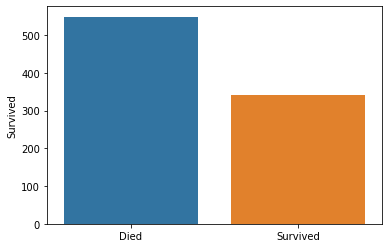

In [719]:
# total percentage of survivors from the crash

survived = train.Survived.value_counts()
survived.index = ['Died', 'Survived']

sns.barplot(x=survived.index, y=survived)
plt.show()

We can see that around 5/8 of the passengers about the Titanic died, and around 3/8 survived overall

Next, we will look at the SibSp and Parch columns.

SibSp: Number of passengers siblings or spouses on the Titanic
    
Parch: Number of passengers parents or kids aboard.


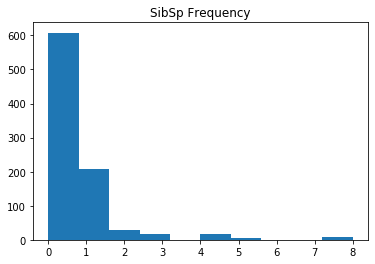

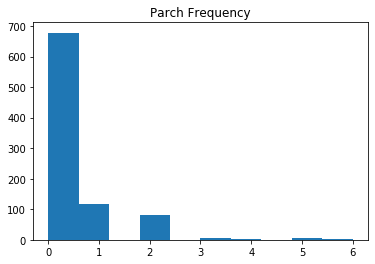

In [720]:
# charting histogram of SibSp
plt.hist(train.SibSp)
plt.title("SibSp Frequency")
plt.show()


# charting histogram of Parch
plt.hist(train.Parch)
plt.title("Parch Frequency")
plt.show()


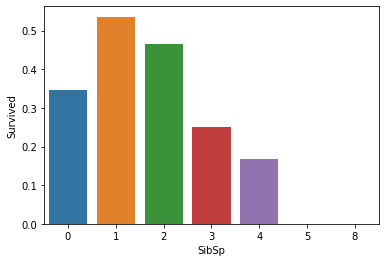

In [721]:
# examining the relationship between SibSP and Survival

# creating pivot table out of sibsp and survival values
sibsp = train.pivot_table(index='SibSp', values='Survived')

#charting survival rates by sibsp values
sns.barplot(x=sibsp.index, y=sibsp['Survived'])
plt.show()

We can see that the fewer the siblings/spouses, the more likely a person was to survive with the exception of those with no siblings/spouses.

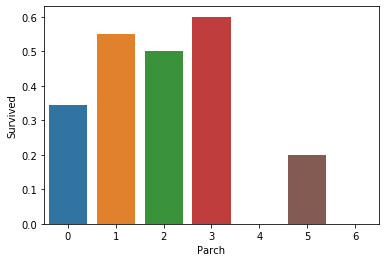

In [722]:
# examining the relationship between Parch and Survival

# creating pivot table out of Parch and survival values
parch = train.pivot_table(index='Parch', values='Survived')

#charting survival rates by Parch values
sns.barplot(x=parch.index, y=parch['Survived'])
plt.show()

The number of Parents/Children seems to have a moderately linear opposite effect than sibsp, with higher numbers showing a positive survival rate increase, until reaching a value of four.  This could be an outlier value.  Let's see how many passengers out of 891 had a Parch value of 4, 5, and 6.

In [723]:
# number of passengers with parch value of 4, 5, and 6

for i in range(4,7):
    print("Number of passengers with value", i, "for Parch: ",train[train.Parch == i].shape[0])


Number of passengers with value 4 for Parch:  4
Number of passengers with value 5 for Parch:  5
Number of passengers with value 6 for Parch:  1


We can see that these numbers for large values of Parch are very unreliable to make too much of due to the tiny sample size.

In [724]:
# checking the numerican values of SibSp and Parch

print(train.SibSp.describe())

print('\n')

print(train.Parch.describe())

count    891.000000
mean       0.523008
std        1.102743
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        8.000000
Name: SibSp, dtype: float64


count    891.000000
mean       0.381594
std        0.806057
min        0.000000
25%        0.000000
50%        0.000000
75%        0.000000
max        6.000000
Name: Parch, dtype: float64


Now, we will combine Parch and SibSp into a single column, which will represent how many family members each passenger had on board the titanic, and look at the survival rates for each number.

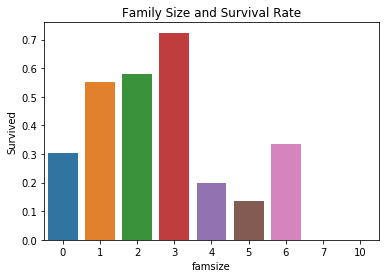

In [725]:
# combining Parch and SibSp into a single column
train['famsize'] = train.Parch + train.SibSp
holdout['famsize'] = train.Parch + train.SibSp

# creating pivot table to calculate survival rates for each psib value
famsize = train.pivot_table(index='famsize', values='Survived')

# charting survival data
sns.barplot(x=famsize.index, y=famsize.Survived)
plt.title("Family Size and Survival Rate")
plt.show()

Observing the values in the Family Size chart, the only thing in common between this and the SibSp and Parch charts are that those with no siblings/spouses, and no parents/children are less likely to survive.

Because of this, we will create a new column called is_alone, where the value will be a 1 if they are alone, or 0 if they have any family on board the Titanic.

In [726]:
# creating new column is_alone in both training and holdout datasets

# function to create is_alone column
def is_alone_func(row):
    if row.famsize == 0:
        row['is_alone'] = 1 
    else:
        row['is_alone'] = 0
    return row

# applying function to both training and holdout datasets
train = train.apply(is_alone_func, axis=1)
holdout = holdout.apply(is_alone_func, axis=1)


In [727]:
# verifying new columns was created in train
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_T,Cabin_type_Unknown,famsize,is_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,0,0,0,0,0,0,0,1,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,0,1,0,0,0,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,0,0,0,0,0,0,0,1,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,0,1,0,0,0,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,0,0,0,0,0,0,0,1,0,1


In [728]:
# verifying new columns was created in holdout
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,...,Cabin_type_A,Cabin_type_B,Cabin_type_C,Cabin_type_D,Cabin_type_E,Cabin_type_F,Cabin_type_G,Cabin_type_Unknown,famsize,is_alone
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q,...,0,0,0,0,0,0,0,1,1,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S,...,0,0,0,0,0,0,0,1,1,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q,...,0,0,0,0,0,0,0,1,0,1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S,...,0,0,0,0,0,0,0,1,1,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S,...,0,0,0,0,0,0,0,1,0,1


In [729]:
# dropping famsize column from both dataframes
train.drop('famsize', axis=1, inplace=True)
holdout.drop('famsize', axis=1, inplace=True)

## Feature Selection

Now we will determine what features to use in out machine learning algorithms.  We will be using sklearns feature selection optimization tool: sklearn.feature_selection.RFECV

This tool uses recursive elimination to choose the optimal features for us in combination with a algorithm selected by the user.  In this case, we will be using random forest classifier to make our predictions.

First, we will write a function that will:

- Have a dataframe as a parameter


- perform any necessary data preparation


- use RFECV and random forest classifier to perform feature selection

In [730]:
# importing RFECV and Random Forest Classifier
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier


# creating function best_features

def best_features(df):
    # breaking down train into features (all_X) and label(all_y) 
    all_X = df.copy()
    all_X.drop(['PassengerId', 'Survived'], axis=1, inplace=True)

    all_X = all_X.select_dtypes(include=[np.number])
    all_y = df.Survived
    
    # instantiating random forest classifier object
    rf = RandomForestClassifier(random_state=0)
    
    # running RFECV on random forest
    selector = RFECV(rf, cv=10, n_jobs=8)
    selector.fit(all_X, all_y)
    
    # printing out the best feature columns
    best_cols = all_X.columns[selector.support_]
    print(best_cols)
    
    # return best columns
    return best_cols


# performing funtion on train data
feat_cols = best_features(train)
feat_cols
    

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown',
       'is_alone'],
      dtype='object')


Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Fare_categories_0-12', 'Fare_categories_12-50',
       'Fare_categories_50-100', 'Fare_categories_100+', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown',
       'is_alone'],
      dtype='object')

## Model Selection and Tuning

We would like create a function that will:

Loop through three different dictionaries contained in a list.  Each dictionary will contain:

- The name of the algorithm we are using (K Nearest Neighbors, Random Forest, and Logistic Regression)


- The python object of the algorithm itself


- a sub-dictionary of all the hyperparameters we would like our grid-search optimization program to run through while optimizing.

In [731]:
# importing necessary modules
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#creating function to run and optimize three different models on our feature columns
def best_model(df, feature_list):
    
    # narrowing down our all_X cols to just the optimal features
    all_X = df[feature_list]
    all_y = df['Survived']
    
    list_of_dicts = [
                        {
                         'name': 'K Nearest Neighbors',
                         'estimator': KNeighborsClassifier(),
                         'hyperparameters':
                              {
                                "n_neighbors": range(1,20,2),
                                "weights": ["distance", "uniform"],
                                "algorithm": ["ball_tree", "kd_tree", "brute"],
                                "p": [1,2]
                               }
                         },
                         
                         {'name': 'Logistic Regression',
                         'estimator': LogisticRegression(),
                         'hyperparameters': {"solver": ["newton-cg", "lbfgs", "liblinear"]}},
                         
                          
                         {'name': 'Random Forest Classifier',
                          'estimator': RandomForestClassifier(),
                          'hyperparameters':
                              {
                               "n_estimators": [4, 6, 9],
                                "criterion": ["entropy", "gini"],
                                "max_depth": [2, 5, 10],
                                "max_features": ["log2", "sqrt"],
                                "min_samples_leaf": [1, 5, 8],
                                "min_samples_split": [2, 3, 5]
                              }
                          } 
                         
                
                     ]
    # looping over each dictionary, performing a grid search over hyperparameters,
    #
    for dict in list_of_dicts:
        
        # creating grid object, passing in arguments from our dictionary into the parameters of grid search
        grid = GridSearchCV(dict['estimator'], param_grid=dict['hyperparameters'], cv=10, n_jobs=-1)
        
        # fitting the data from all_X, all_y
        grid.fit(all_X, all_y)
        
        
        # updating our dictionary with best score, best parameters and best estimator from grid search
        dict['best_params'] = grid.best_params_
        dict['best_score'] = grid.best_score_
        dict['best_estimator'] = grid.best_estimator_
        
        # printing best core, best parameters and best estimator from grid search
        print("Best results from grid search using", dict['name'])
        print("best_params: ", grid.best_params_)
        print('best_score: ', grid.best_score_)
        print('best_estimator: ', grid.best_estimator_)
        print('\n')
    
    return list_of_dicts
        
results = best_model(train, feat_cols)

Best results from grid search using K Nearest Neighbors
best_params:  {'algorithm': 'brute', 'n_neighbors': 11, 'p': 1, 'weights': 'distance'}
best_score:  0.7633083645443196
best_estimator:  KNeighborsClassifier(algorithm='brute', n_neighbors=11, p=1, weights='distance')


Best results from grid search using Logistic Regression
best_params:  {'solver': 'newton-cg'}
best_score:  0.8249563046192259
best_estimator:  LogisticRegression(solver='newton-cg')


Best results from grid search using Random Forest Classifier
best_params:  {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 9}
best_score:  0.8440449438202249
best_estimator:  RandomForestClassifier(criterion='entropy', max_depth=10, max_features='sqrt',
                       min_samples_split=5, n_estimators=9)




## Submitting to Kaggle.com

Now that we've made our way through the work flow cycle for the first time, we should write a function to make it easy to convert our predictions on the holdout data into the proper format for submission to Kaggle.  This will save a lot of time down the road, should we choose to go back and work on data exploration, feature engineering/selection etc.



In [732]:
# define function to predict on holdout data, and save file in proper csv format for submission

def submit(model, feature_cols, filename='submission.csv'):
    
    # choosing only best feature-selected columns for holdout data
    holdout_data = holdout[feat_cols]
    
    # creating predictions
    predictions = model.predict(holdout_data)
    
    # creating dictionary to hold data
    new_dict = {
                'PassengerId' : holdout.PassengerId,
                'Survived' : predictions       
                }
    
    # converting dictionary into dataframe
    df = pd.DataFrame(new_dict)
    
    # saving file as a csv for submission
    df.to_csv(filename, index=False)
    
    
# testing function
submit(results[0]['best_estimator'], feat_cols)